# Playing with gradient methods

[Source](https://ee227c.github.io/)  

In this note, we'll solve some optimization problems using the gradient methods we've seen so far.

* [Projected gradient descent](#Projected-gradient-descent)
* [Warm-up: Quadratics](#warmup)
* [Least squares](#least-squares)
* [Regularization](#regularization)
* [Implicit regularization](#implicit)
* [Gradient madness](#madness)

Ignore the next code box.

In [3]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(606)

kwargs = {'linewidth' : 3.5}
font = {'weight' : 'normal', 'size'   : 24}
matplotlib.rc('font', **font)

def error_plot(ys, yscale='log'):
    plt.figure(figsize=(8, 8))
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.yscale(yscale)
    plt.plot(range(len(ys)), ys, **kwargs)

## Projected gradient descent

We start with a basic implementation of projected gradient descent.

In [4]:
def gradient_descent(init, steps, grad, proj=lambda x: x):
    """Projected gradient descent.
    
    Inputs:
        initial: starting point
        steps: list of scalar step sizes
        grad: function mapping points to gradients
        proj (optional): function mapping points to points
        
    Returns:
        List of all points computed by projected gradient descent.
    """
    xs = [init]
    for step in steps:
        xs.append(proj(xs[-1] - step * grad(xs[-1])))
    return xs

Note that this implementation keeps around all points computed along the way. This is clearly not what you would do on large instances. We do this for illustrative purposes to be able to easily inspect the computed sequence of points.

<a id="warmup"></a>
## Warm-up: Optimizing a quadratic

As a toy example, let's optimize $$f(x)=\frac12\|x\|^2,$$ which has the gradient map $\nabla f(x)=x.$

In [5]:
def quadratic(x):
    return 0.5*x.dot(x)

def quadratic_gradient(x):
    return x

Note the function is $1$-smooth and $1$-strongly convex. Our theorems would then suggest that we use a constant step size of $1.$ If you think about it, for this step size the algorithm will actually find the optimal solution in just one step.

In [6]:
x0 = np.random.normal(0, 1, (1000))
_, x1 = gradient_descent(x0, [1.0], quadratic_gradient)

Indeed, it does.

In [7]:
x1.all() == 0

True

Let's say we don't have the right learning rate. 

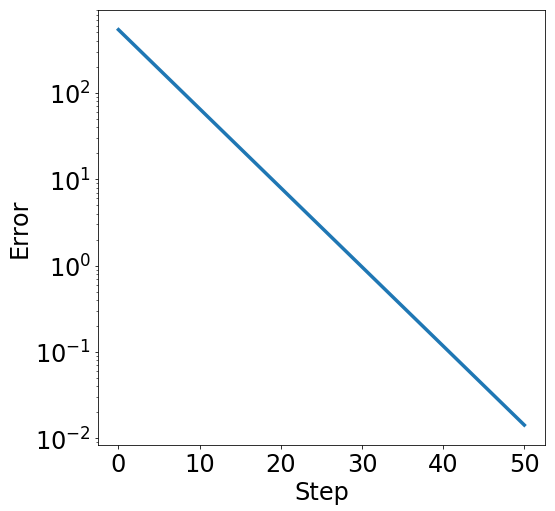

In [8]:
xs = gradient_descent(x0, [0.1]*50, quadratic_gradient)
error_plot([quadratic(x) for x in xs])

### Constrained optimization

Let's say we want to optimize the function inside some affine subspace. Recall that affine subspaces are convex sets. Below we pick a random low dimensional affine subspace $b+U$ and define the corresponding linear projection operator.

In [9]:
# U is an orthonormal basis of a random 100-dimensional subspace.
U = np.linalg.qr(np.random.normal(0, 1, (1000, 100)))[0]
b = np.random.normal(0, 1, 1000)

def proj(x):
    """Projection of x onto an affine subspace"""
    return b + U.dot(U.T).dot(x-b)

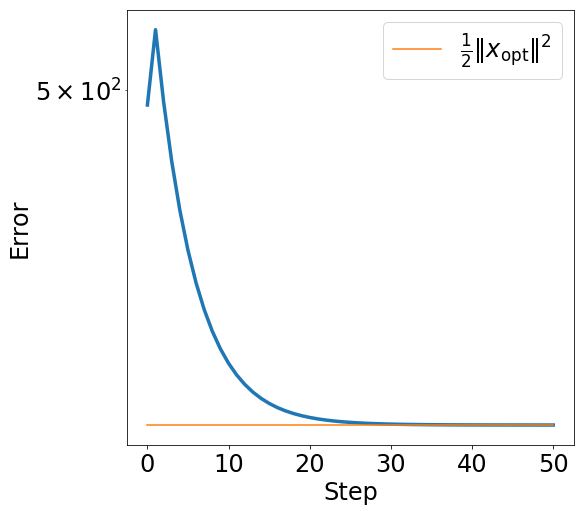

In [10]:
x0 = np.random.normal(0, 1, (1000))
xs = gradient_descent(x0, [0.1]*50, quadratic_gradient, proj)
# the optimal solution is the projection of the origin
x_opt = proj(0)
error_plot([quadratic(x) for x in xs])
plt.plot(range(len(xs)), [quadratic(x_opt)]*len(xs),
        label='$\\frac{1}{2}|\!|x_{\mathrm{opt}}|\!|^2$')
plt.legend()

The orangle line shows the optimal error, which the algorithm reaches quickly. The iterates also converge to the optimal solution in domain as the following plot shows.

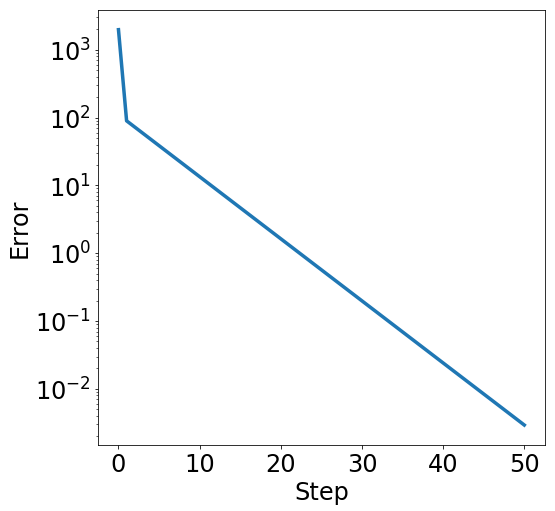

In [11]:
error_plot([np.linalg.norm(x_opt-x)**2 for x in xs])

<a id="least-squares"></a>
## Least Squares 

One of the most fundamental data analysis tools is *linear least squares*. Given an $m\times n$ matrix $A$ and a vector $b$ our goal is to find a vector $x\in\mathbb{R}^n$ that minimizes the following objective: 

<p>
$$f(x) = \frac 1{2m}\sum_{i=1}^m (a_i^\top x - b_j)^2 
=\frac1{2m}\|Ax-b\|^2$$
</p>

We can verify that $\nabla f(x) = A^\top(Ax-b)$ and
$\nabla^2 f(x) = A^\top A.$

Hence, the objective is $\beta$-smooth with 
$\beta=\lambda_{\mathrm{max}}(A^\top A)$, and $\alpha$-strongly convex with $\alpha=\lambda_{\mathrm{min}}(A^\top A)$.

In [12]:
def least_squares(A, b, x):
    """Least squares objective."""
    return (0.5/m) * np.linalg.norm(A.dot(x)-b)**2

def least_squares_gradient(A, b, x):
    """Gradient of least squares objective at x."""
    return A.T.dot(A.dot(x)-b)/m

### Overdetermined case $m\ge n$

In [13]:
m, n = 1000, 100
A = np.random.normal(0, 1, (m, n))
x_opt = np.random.normal(0, 1, n)
noise = np.random.normal(0, 0.1, m)
b = A.dot(x_opt) + noise
objective = lambda x: least_squares(A, b, x)
gradient = lambda x: least_squares_gradient(A, b, x)

#### Convergence in objective

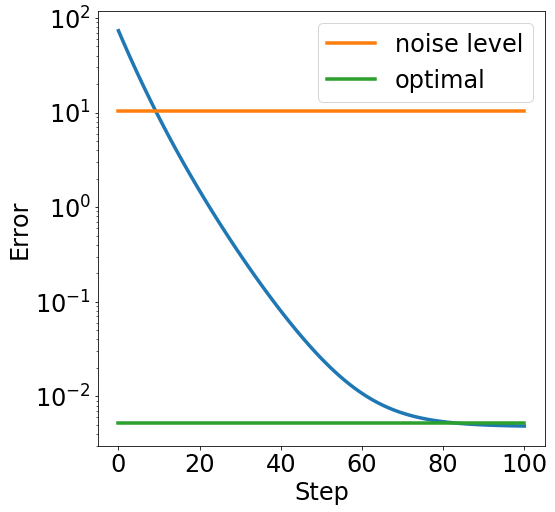

In [14]:
x0 = np.random.normal(0, 1, n)
xs = gradient_descent(x0, [0.1]*100, gradient)
error_plot([objective(x) for x in xs])
plt.plot(range(len(xs)), [np.linalg.norm(noise)**2]*len(xs),
        label='noise level', **kwargs)
plt.plot(range(len(xs)), [least_squares(A,b,x_opt)]*len(xs),
        label='optimal', **kwargs)
_ = plt.legend()

#### Convergence in domain

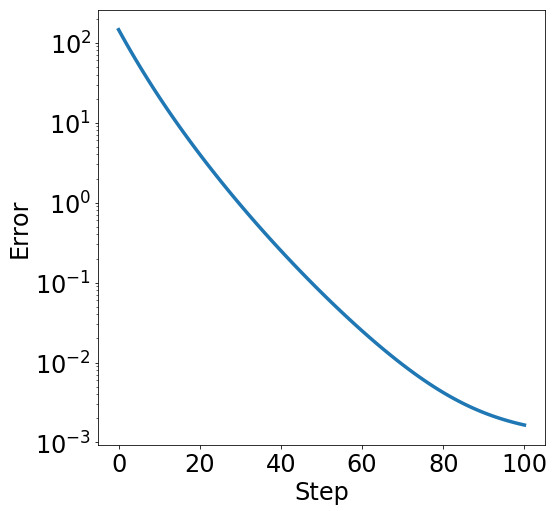

In [15]:
error_plot([np.linalg.norm(x-x_opt)**2 for x in xs])

### Underdetermined case $m < n$

In the underdetermined case, the least squares objective is inevitably not strongly convex, since $A^\top A$ is a rank deficient matrix and hence $\lambda_{\mathrm{min}}(A^\top A)=0.$

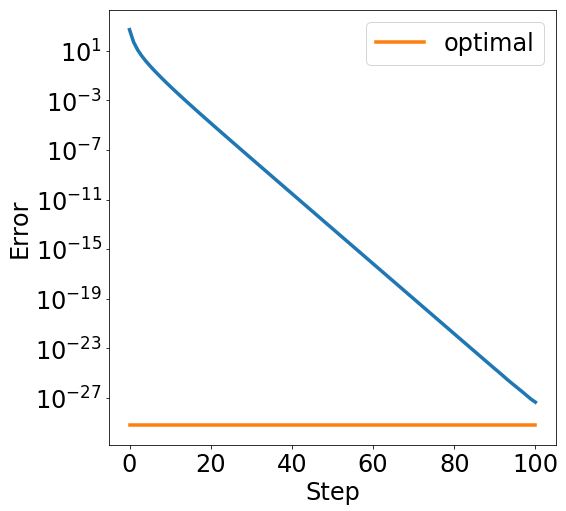

In [16]:
m, n = 100, 1000
A = np.random.normal(0, 1, (m, n))
b = np.random.normal(0, 1, m)
# The least norm solution is given by the pseudo-inverse
x_opt = np.linalg.pinv(A).dot(b)
objective = lambda x: least_squares(A, b, x)
gradient = lambda x: least_squares_gradient(A, b, x)
x0 = np.random.normal(0, 1, n)
xs = gradient_descent(x0, [0.1]*100, gradient)
error_plot([objective(x) for x in xs])
plt.plot(range(len(xs)), [least_squares(A,b,x_opt)]*len(xs),
        label='optimal', **kwargs)
_ = plt.legend()

While we quickly reduce the error, we don't actually converge in domain to the least norm solution. This is just because the function is no longer strongly convex in the underdetermined case.

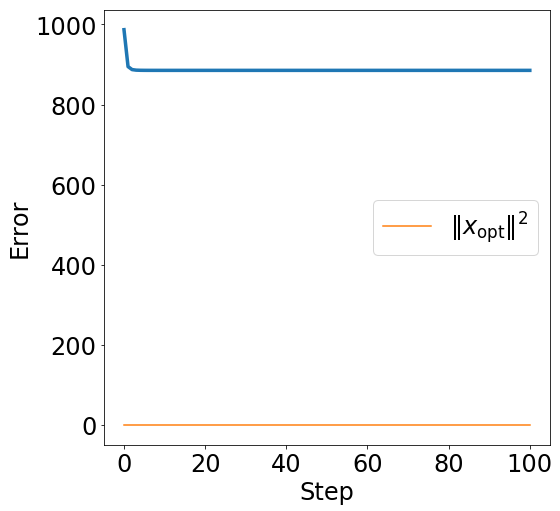

In [17]:
error_plot([np.linalg.norm(x-x_opt)**2 for x in xs], yscale='linear')
plt.plot(range(len(xs)), [np.linalg.norm(x_opt)**2]*len(xs),
         label='$|\!|x_{\mathrm{opt}}|\!|^2$')
plt.legend()

<a id="regularization"></a>

## $\ell_2$-regularized least squares

In the underdetermined case, it is often desirable to restore strong convexity of the objective function by adding an $\ell_2^2$-penality, also known as *Tikhonov regularization*, $\ell_2$-regularization, or *weight decay*.

<p>
$$\frac1{2m}\|Ax-b\|^2 + \frac{\alpha}2\|x\|^2$$
</p>

Note: With this modification the objective is $\alpha$-strongly convex again.


In [18]:
def least_squares_l2(A, b, x, alpha=0.1):
    return least_squares(A, b, x) + (alpha/2) * x.dot(x)

def least_squares_l2_gradient(A, b, x, alpha=0.1):
    return least_squares_gradient(A, b, x) + alpha * x

Let's create a least squares instance.

In [19]:
m, n = 100, 1000
A = np.random.normal(0, 1, (m, n))
b = A.dot(np.random.normal(0, 1, n))
objective = lambda x: least_squares_l2(A, b, x)
gradient = lambda x: least_squares_l2_gradient(A, b, x)

Note that we can find the optimal solution to the optimization problem in closed form without even running gradient descent by computing $x_{\mathrm{opt}}=(A^\top+\alpha I)^{-1}A^\top b.$ Please verify that this point is indeed optimal.

In [20]:
x_opt = np.linalg.inv(A.T.dot(A) + 0.1*np.eye(1000)).dot(A.T).dot(b)

Here's how gradient descent fares.

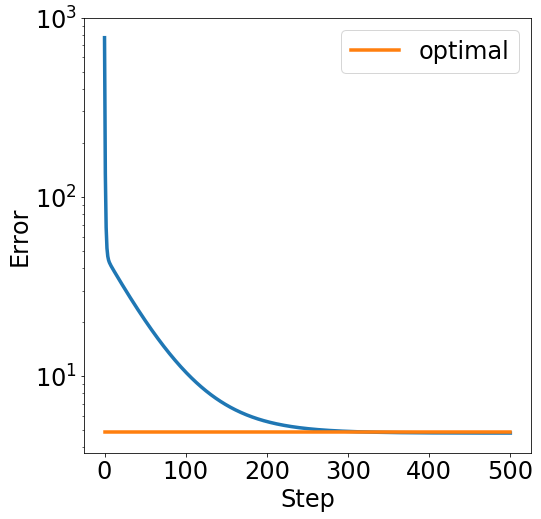

In [21]:
x0 = np.random.normal(0, 1, n)
xs = gradient_descent(x0, [0.1]*500, gradient)
error_plot([objective(x) for x in xs])
plt.plot(range(len(xs)), [least_squares_l2(A,b,x_opt)]*len(xs),
        label='optimal', **kwargs)
_ = plt.legend()

You see that the error doesn't decrease below a certain level due to the regularization term. This is not a bad thing. In fact, the regularization term gives as *strong convexity* which leads to convergence in domain again:

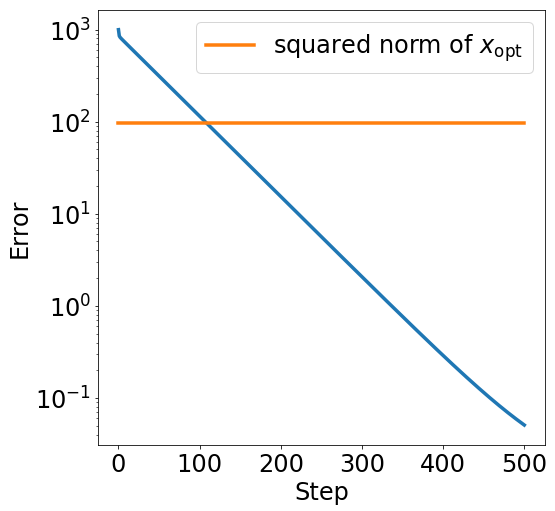

In [22]:
xs = gradient_descent(x0, [0.1]*500, gradient)
error_plot([np.linalg.norm(x-x_opt)**2 for x in xs])
plt.plot(range(len(xs)), [np.linalg.norm(x_opt)**2]*len(xs),
        label='squared norm of $x_{\mathrm{opt}}$', **kwargs)
_ = plt.legend()

<a id="implicit"></a>
## The magic of implicit regularization

Sometimes simply running gradient descent from a suitable initial point has a regularizing effect on its own **without introducing an explicit regularization term**.

We will see this below where we revisit the unregularized least squares objective, but initialize gradient descent from the origin rather than a random gaussian point.

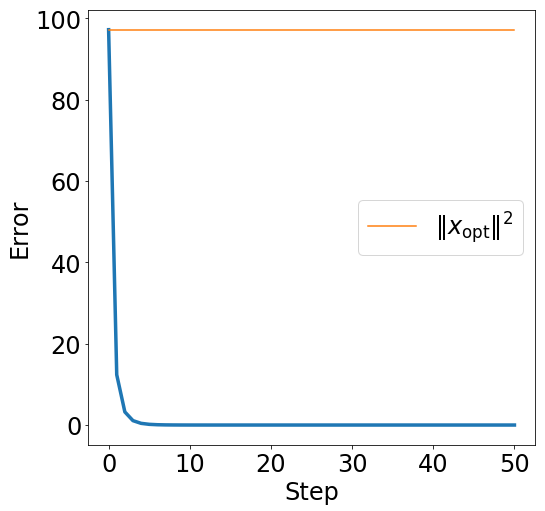

In [23]:
# We initialize from 0
x0 = np.zeros(n)
# Note this is the gradient w.r.t. the unregularized objective!
gradient = lambda x: least_squares_gradient(A, b, x)
xs = gradient_descent(x0, [0.1]*50, gradient)
error_plot([np.linalg.norm(x_opt-x)**2 for x in xs], yscale='linear')
plt.plot(range(len(xs)), [np.linalg.norm(x_opt)**2]*len(xs),
         label='$|\!|x_{\mathrm{opt}}|\!|^2$')
plt.legend()

*Incredible!* We converge to the minimum norm solution!

Implicit regularization is a deep phenomenon that's an active research topic in learning and optimization. It's exciting that we see it play out in this simple least squares problem already!

<a id="inverse"></a>
## Sparse Inverse Covariance Estimation

Given a positive semidefinite matrix $S\in\mathbb{R}^{n\times n}$ the objective function in sparse inverse covariance estimation is as follows:

<p>
$$ \min_{X\in\mathbb{R}^{n\times n}, X\succeq 0} 
\langle S, X\rangle - \log\det(X) + \alpha\|X\|_1$$
</p>

Here, we define
$$\langle S, X\rangle = \mathrm{trace}(S^\top X)$$
and
$$\|X\|_1 = \sum_{ij}|X_{ij}|.$$

Typically, we think of the matrix $S$ as a sample covariance matrix of a set of vectors $a_1,\dots, a_m,$ defined as:
$$
S = \frac1{m-1}\sum_{i=1}^n a_ia_i^\top
$$
The example also highlights the utility of automatic differentiation as provided by the `autograd` package that we'll regularly use. In a later lecture we will understand exactly how automatic differentiation works. For now we just treat it as a blackbox that gives us gradients.

In [ ]:
import autograd.numpy as np
from autograd import grad

np.random.seed(1337)

In [ ]:
def sparse_inv_cov(S, X, alpha=0.1):
    return (np.trace(S.T.dot(X))
            - np.log(np.linalg.det(X))
            + alpha * np.sum(np.abs(X)))

In [ ]:
n = 5
A = np.random.normal(0, 1, (n, n))
S = A.dot(A.T)
objective = lambda X: sparse_inv_cov(S, X)
# autograd provides a "gradient", yay!
gradient = grad(objective)

We also need to worry about the projection onto the positive semidefinite cone, which corresponds to truncating eigenvalues.

In [ ]:
def projection(X):
    """Projection onto positive semidefinite cone."""
    es, U = np.linalg.eig(X)
    es[es<0] = 0.
    return U.dot(np.diag(es).dot(U.T))

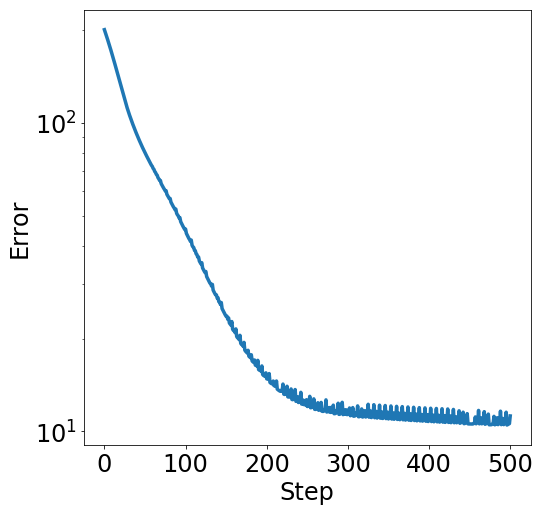

In [ ]:
A0 = np.random.normal(0, 1, (n,n))
X0 = A0.dot(A0.T)
Xs = gradient_descent(X0, [0.01]*500, gradient, projection)
error_plot([objective(X) for X in Xs])

<a id="madness"></a>

# Going crazy with autograd

Just for fun, we'll go through a crazy example below. We can use `autograd` not just for getting gradients for natural objectives, we can in principle also use it to tune hyperparameters of our optimizer, like the step size schedulde.

Below we see how we can find a better 10-step learning rate schedules for optimizing a quadratic. This is mostly just for illustrative purposes (although some researchers are exploring these kinds of ideas more seriously).

In [ ]:
x0 = np.random.normal(0, 1, 1000)

In [ ]:
def f(x):
    return 0.5*np.dot(x,x)

def optimizer(steps):
    """Optimize a quadratic with the given steps."""
    xs = gradient_descent(x0, steps, grad(f))
    return f(xs[-1])

The function `optimizer` is a non-differentiable function of its input `steps`. Nontheless, `autograd` will provide a gradient that we can stick into gradient descent. That is, we're tuning gradient descent with gradient descent.

In [ ]:
grad_optimizer = grad(optimizer)

In [ ]:
initial_steps = np.abs(np.random.normal(0, 0.1, 10))
better_steps = gradient_descent(initial_steps, [0.001]*500, grad_optimizer)

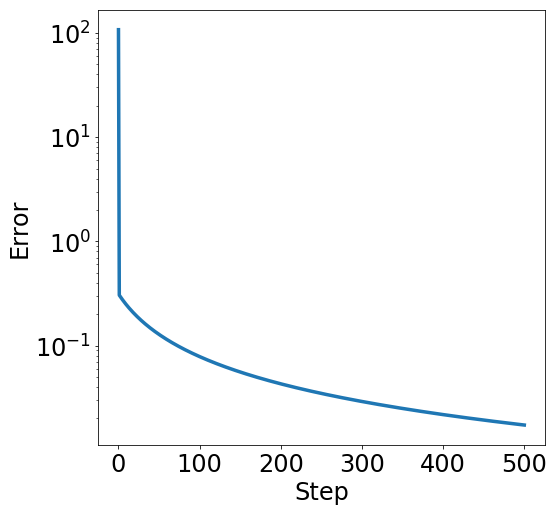

In [ ]:
error_plot([optimizer(steps) for steps in better_steps])

As we can see, the learning rate schedules improve dramatically over time. Of course, we already know from the first example that there is a step size schedule that converges in one step. Interestingly, the last schedule we find here doesn't look at all like what we might expect:

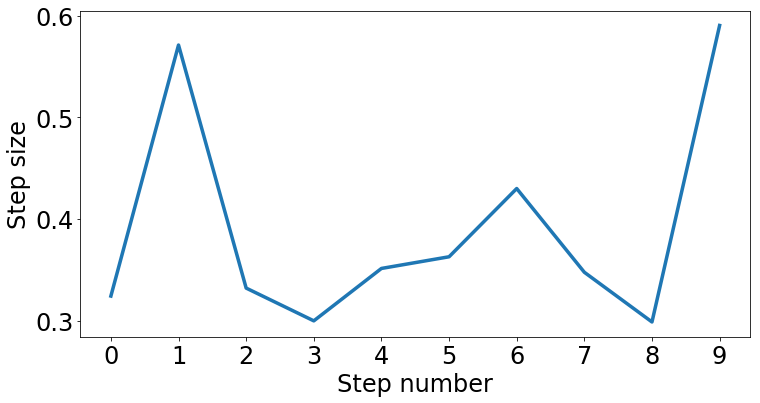

In [ ]:
plt.figure(figsize=(12,6))
plt.xticks(range(len(better_steps[-1])))
plt.ylabel('Step size')
plt.xlabel('Step number')
plt.plot(range(len(better_steps[-1])), better_steps[-1], **kwargs)